In [ ]:
!python --version

Python 3.10.12


In [ ]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


/


In [ ]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

 # Import Libraries

In [ ]:
!pip install rasterio

In [ ]:
# Essentials
import numpy as np
import pandas as pd
import tables
from functools import partial

# For Ploting
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
import seaborn as sns
from IPython.display import HTML
%matplotlib inline
from rasterio import rio
from rasterio.plot import show

# For Scipy
from scipy import interp
from scipy.stats import wilcoxon, mannwhitneyu, friedmanchisquare, ttest_ind

# For Sci-Kit Learn
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier

from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier

from sklearn.model_selection import cross_validate, cross_val_score,cross_val_predict, KFold, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, log_loss, make_scorer, auc, roc_curve,brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import random

# For HyperOpt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, rand, space_eval
from hyperopt.pyll import scope as hp_scope
from hyperopt.pyll.stochastic import sample as ho_sample

# OS Specific
from pathlib import Path
import time

# Geo-Data
import geopandas as gpd
import rasterio as rio
from osgeo import gdal,ogr

#For Markdown
from tabulate import tabulate


In [ ]:
count = 0

In [ ]:
# Init. Project Folder Path
projhome = Path.cwd()

# Number of CPUs to use in Optimization
cpus = 2

# Set the RandomState of the seed:
seed = 101
rng = np.random.RandomState(seed)
np.random.seed(seed)
print ("Random number with seed 30")
random.seed(seed)


Random number with seed 30


In [ ]:
# Load Input Data
def load_data(data):
    try:
        df = pd.read_csv(data)
        return df
    except IOError:
        print("IOError: The file is not available...Check if it exist!")


# Dataset Path
data_path = "/content/ML_Analysis_original.csv"
input_df = load_data(data_path)
input_df = input_df.iloc[:,1:]


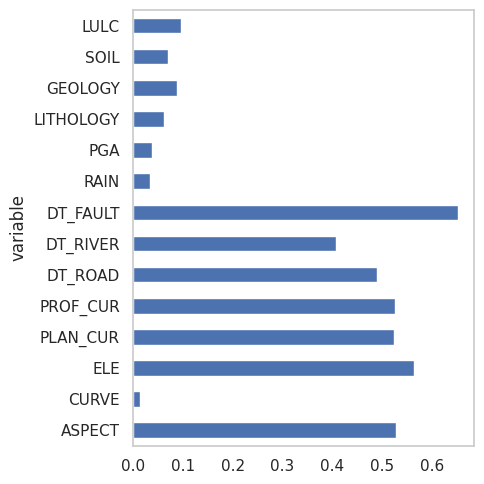

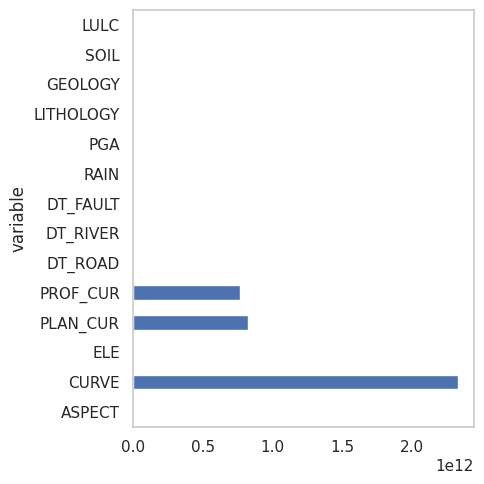

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

# Create necessary directories
os.makedirs("./Output/Tables", exist_ok=True)
os.makedirs("./Output/Figures", exist_ok=True)

# Assuming input_df is already defined and contains your data
# Ensure the Landslides column contains discrete values
input_df['Landslides'] = input_df['Landslides'].astype(int)

# Compute the correlation matrix
input_cor = input_df.drop("Landslides", axis=1).corr()

# Compute info-Gain
gain_df = {
    "variable": input_df.drop("Landslides", axis=1).columns,
    "gain": mutual_info_classif(input_df.drop("Landslides", axis=1), input_df["Landslides"], discrete_features=True)
}
gain_df = pd.DataFrame(data=gain_df)
with open("./Output/Tables/gain_df.md", 'w') as tabl:
    print(tabulate(gain_df, headers=['variable', 'gain'], tablefmt="grid"), file=tabl)

# Use seaborn styles directly
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(5, 5))
gain_df.plot.barh(x="variable", y="gain", ax=ax, legend=False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
fig.tight_layout()
plt.savefig('./Output/Figures/gain_plot.jpg', dpi=300, bbox_inches="tight")

# Compute the VIF
vifs = pd.DataFrame(data={"vif": np.linalg.inv(input_cor.values).diagonal(), "variable": input_cor.index})
with open("./Output/Tables/vif_df.md", 'w') as tabl:
    print(tabulate(vifs, headers=['variable', 'vif'], tablefmt="grid"), file=tabl)

fig, ax = plt.subplots(figsize=(5, 5))
vifs.plot.barh(x="variable", y="vif", ax=ax, legend=False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
fig.tight_layout()
plt.savefig('./Output/Figures/vif_plot.jpg', dpi=300, bbox_inches="tight")

 # Init. the necessary functions

In [ ]:
# Init. the splitting function:
def cv_splitting(features, labels, cv, inner_cv=None):
    '''
    0 Refer to Features
    1 Refer to Labels
    '''
    X_train_out = []
    Y_train_out = []
    X_test_out = []
    Y_test_out = []
    print("Splitting the Input data according to The resampling...")
    for i, (train_idx, test_idx) in enumerate(cv.split(features, labels)):
        print("Fold number %d...." % (i), end=" ")
        X_train_out.append(features[train_idx])
        Y_train_out.append(labels[train_idx])
        X_test_out.append(features[test_idx])
        Y_test_out.append(labels[test_idx])
        print("done.")
    return X_train_out,Y_train_out,X_test_out,Y_test_out

In [ ]:

def objective_func(params, xdata, clf, ydata, cv_resample, metric="roc_auc"):
    global count
    count += 1
    lrn_clf = clf
    lrn_clf = lrn_clf.set_params(**params)
    obj_scores_roc = []
    obj_scores_accuracy = []

    for i, (X, Y) in enumerate(zip(xdata, ydata)):
        cv_score_roc = cross_val_score(lrn_clf, X=X, y=Y, scoring=metric, cv=cv_resample, error_score='raise').mean()
        cv_score_accuracy = cross_val_score(lrn_clf, X=X, y=Y, scoring='accuracy', cv=cv_resample, error_score='raise').mean()

        if cv_score_roc is not None and cv_score_accuracy is not None:
            obj_scores_roc.append(cv_score_roc)
            obj_scores_accuracy.append(cv_score_accuracy)

    mean_roc_auc = np.mean(obj_scores_roc)
    mean_accuracy = np.mean(obj_scores_accuracy)
    loss = -mean_roc_auc  # We keep the loss as negative ROC AUC for optimization purposes

    print(f'''\n Results\n
    Iterations: {count}
    Loss (negative ROC AUC): {loss:.5f}
    Accuracy: {mean_accuracy:.5f}
    using: {params}\n''')

    return {'loss': loss, 'roc_auc': mean_roc_auc, 'accuracy': mean_accuracy, 'status': STATUS_OK}

In [ ]:
# Output the optimization trails function
def optimization_trails(trails,search_space):

    best_hp = dict([(k,np.NaN) if not v else (k,v[0]) for k,v in trails.best_trial["misc"]["vals"].items()])
    best_hp = space_eval(search_space,best_hp)
    best_hp["tid"] = trails.best_trial["misc"]["tid"]
    best_hp["loss"] = trails.best_trial["result"]["loss"]
    best_hp["status"] = trails.best_trial["result"]["status"]
    best_hp = pd.DataFrame.from_dict([best_hp])

    optimization_df = []
    for idx, value in enumerate(trails.trials):
        optimization_dic = dict([(k,np.NaN) if not v else (k,v[0]) for k,v in value["misc"]["vals"].items()])
        optimization_dic = space_eval(search_space,optimization_dic)
        optimization_dic["tid"] = value["misc"]["tid"]
        optimization_dic["loss"] = value["result"]["loss"]
        optimization_dic["status"] = value["result"]["status"]
        optimization_df.append(optimization_dic)

    optimization_df = pd.DataFrame(optimization_df)
    return optimization_df, best_hp

In [ ]:
def optimization_history(trails):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12), sharex=True)

    iterations = range(1, len(trails) + 1)
    roc_auc_scores = [-x['result']['loss'] for x in trails]  # Assuming loss is negative ROC AUC
    accuracy_scores = [x['result']['accuracy'] for x in trails]  # Make sure 'accuracy' is returned in your objective function

    # ROC AUC subplot
    ax1.scatter(iterations, roc_auc_scores,
                edgecolor='black', c="C1", linewidth=1,
                s=80, zorder=2, label="ROC AUC")
    ax1.set_ylabel('ROC AUC', fontsize=12)
    ax1.set_title('Optimization History', fontsize=14)
    ax1.grid("on", linestyle='--', linewidth=1, alpha=0.3)
    ax1.legend()

    # Accuracy subplot
    ax2.scatter(iterations, accuracy_scores,
                edgecolor='black', c="C2", linewidth=1,
                s=80, zorder=2, label="Accuracy")
    ax2.set_xlabel('Iteration', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.grid("on", linestyle='--', linewidth=1, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    return fig, (ax1, ax2)

In [ ]:
# Train and evaluate the final model
def tunned_model_evaluation(clf,opt_hp,x,y,cv,scores):
    print(f"Train & and validate using the Following Parameters: \n {opt_hp}")
    lrn_clf = clf
    lrn_clf = lrn_clf.set_params(**opt_hp)

    # generate scores metrics
    final = cross_validate(lrn_clf, X=x, y=y, cv=cv,scoring=scores, return_train_score=True)
    # final_prob = cross_val_predict(lrn_clf, X=x, y=y, cv=cv,method="predict_proba")

    # Formating the exported scores
    scores_raw = pd.DataFrame(data=final)
    scores = pd.DataFrame({"mean":np.mean(scores_raw), "std":np.std(scores_raw)})
    return scores, scores_raw

 ## Significance test and Pair-wise analysis

In [ ]:
# Wilcoxon Pair-wise analysis
def sig_stat(data_list,data_names):

    pval = []
    statval = []
    pair = []

    for idx in range(0,len(data_list),1):
        if idx < len(data_list):
            i = idx+1
            while i < len(data_list):
                t, p = ttest_ind(data_list[idx], data_list[i], equal_var = False)
                # t, p = mannwhitneyu(data_list[idx].values, data_list[i].values)
                statval.append(round(t,3))
                pval.append(round(p,4))
                pair.append(f"{data_names[idx]} vs. {data_names[i]}")
                # print(f"{idx}     {i}")
                print(f"{data_names[idx]} vs. {data_names[i]}:\nT: {t} \t p: {p}")
                i += 1
            else:
                continue
        else:
            break
    return pd.DataFrame({"Pairwise":pair,"p.value":pval,"t.value":statval})

## Classification and ROC analysis

In [ ]:
# Run classifier with cross-validation and plot ROC curves
# Compute ROC curve and area the curve function
def generate_roc_data(clf,train_x,train_y,test_x,test_y):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for x,y,xt,yt in zip(train_x,train_y,test_x,test_y):
        probas_ = clf.fit(x, y).predict_proba(xt)
        # Compute ROC curve and area the curve
        fpr, tpr, _ = roc_curve(yt, probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    return (fpr, tpr, roc_auc), (mean_fpr, mean_tpr, mean_auc, std_auc,tprs_upper,tprs_lower,std_tpr)
# Plot all roc plots function
def plot_roc_curves(roc_data,roc_data_names):
    mpl.style.use("seaborn-paper")
    # custom_cycler = cycler('linestyle',['-','--',':','-.'])
    custom_cycler = (cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                                '#bcbd22', '#17becf']) +
                                cycler(linestyle=['-','--',':','-.','-','--',':','-.','-','--'])
                                )
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot([0, 1], [0, 1], linestyle=':', lw=0.8, alpha=.8,
                color='k',
                # label='Luck'
                )
    ax.set_prop_cycle(custom_cycler)
    # return (fpr, tpr, roc_auc), (mean_fpr, mean_tpr, mean_auc, std_auc,tprs_upper,tprs_lower,std_tpr)
    for idx, value in enumerate(roc_data):
        ax.plot(value[0], value[1], \
                    # color='C1',
                    label=f"{roc_data_names[idx]} AUC-ROC = {value[2]:0.3f} +/- {value[3]:0.3f}",
                    lw=1.4)
                    # lw=1.4, alpha=.8)
        # ax.fill_between(value[0], value[5], value[4],
        #             # label=f"+/- 1 std. dev.",
        #             # color='grey',
        #             alpha=.1
        #             )

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    # ax.set_title('Receiver operating characteristic curve')
    ax.legend(loc="lower right")
    return fig, ax

 Calibration analysis

In [ ]:
# Probability Calibration curves function
def plot_calibration_curves(clf,x,y,test_size,cv, seed, clf_name):
    from sklearn.metrics import brier_score_loss
    custom_cycler = (cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                                '#bcbd22', '#17becf']) +
                                cycler(marker=['o', 'X', 's', '8', '>', '*',"h","v","p","d"]) +
                                cycler(linestyle=['-','--',':','-.','-','--',':','-.','-','--'])
                                )
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size,random_state=101)

    fig,ax1 = plt.subplots(figsize=(7, 7))
    # fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8, 8))
    ax1.set_prop_cycle(custom_cycler)
    # ax2.set_prop_cycle(custom_cycler)
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for lrn, lrn_name in zip(clf, clf_name):
        """Plot calibration curve for clf w/o and with calibration. """
        # Calibrated with isotonic calibration
        isotonic = CalibratedClassifierCV(lrn, cv=cv, method='isotonic')
        # Calibrated with sigmoid calibration
        sigmoid = CalibratedClassifierCV(lrn, cv=cv, method='sigmoid')
        # Logistic regression with no calibration as baseline
        # lr = LogisticRegression(C=1., solver='lbfgs')

        def generate_calibration_data(model,X_train,y_train,X_test,y_test):
            model.fit(X_train, y_train)
            # y_pred = lrn_clf.predict(X_test)
            if hasattr(model, "predict_proba"):
                prob_pos = model.predict_proba(X_test)[:, 1]
            else:  # use decision function
                prob_pos = model.decision_function(X_test)
                prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

            fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
            lrn_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
            return fraction_of_positives, mean_predicted_value, lrn_score, prob_pos


        for lrn_clf, name in [(lrn, lrn_name)
                        # (isotonic, lrn_name + ' + Isotonic'),
                        # (sigmoid, lrn_name + ' + Sigmoid')
                        ]:
            fop, mpv, lss, pp = generate_calibration_data(lrn_clf,X_train,y_train,X_test,y_test)
            # ax1.plot(mpv, fop,alpha=0.75,label=f"{name} {lss:1.3f}")
            ax1.plot(mpv, fop,label=f"{name}")
            # ax2.hist(pp, range=(0, 1),linestyle="-", bins=10,\
            #  label=name,histtype="step",alpha=0.75, lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_xlabel("Mean predicted value")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")

    # ax1.set_title('Calibration plots  (reliability curve)')

    # ax2.set_xlabel("Mean predicted value")
    # ax2.set_ylabel("Count")
    # ax2.legend(loc="upper center", ncol=2)
    # mpl.style.use("seaborn-paper")
    fig.tight_layout()
    # return fig, (ax1,ax2)
    return fig, (ax1)

 Prediction analysis

In [ ]:
def perform_prediction(clf,clf_names, train_data,predict_data,bins=None,bins_labels=None,XY=None,export_prediction=False,export_csv=False):
    prediction = []
    prediction_classified = []
    freq_summary = []
    for lrn_clf, lrn_clf_name in zip(clf,clf_names) :
        # print(f"Train & and validate using the Following Parameters:")
        lrn_clf_prediction = lrn_clf.fit(train_data[0], train_data[1]).predict_proba(predict_data)[:,-1]
        prediction.append(lrn_clf_prediction)

        if bins is not None:
            bins = np.array(bins)
            lrn_clf_prediction_classified = np.digitize(lrn_clf_prediction, bins)
            prediction_classified.append(lrn_clf_prediction_classified)

            unique_class, unique_count = np.unique(lrn_clf_prediction_classified,return_counts=True,axis=0)
            model = np.repeat(lrn_clf_name,len(unique_class))
            unique_count_percentage = (unique_count / np.sum(unique_count,axis=0))*100
            freq_summary.append(np.column_stack((unique_class,unique_count, unique_count_percentage,model)))

    freq_summary = np.row_stack((freq_summary))
    freq_summary = pd.DataFrame(data=freq_summary,columns=["class","count","percentage","model"])
    freq_summary["class"] = freq_summary["class"].astype(str)
    freq_summary["count"] = freq_summary["count"].astype(int)
    freq_summary["percentage"] = freq_summary["percentage"].astype(float)
    freq_summary = freq_summary.round({"percentage":3})

    if XY is not None:
        if export_prediction is True:
            prediction = np.column_stack((prediction))
            prediction = np.column_stack((XY,prediction))
            col_names =["x","y"] + clf_names
            prediction = pd.DataFrame(data=prediction,columns=col_names)
            if export_csv is True:
                prediction.to_csv("./Output/Tables/prediction.csv",index=False)
        else:
            prediction_classified = np.column_stack((prediction_classified))
            prediction_classified = np.column_stack((XY,prediction_classified))
            col_names =["x","y"] + clf_names
            prediction_classified = pd.DataFrame(data=prediction_classified,columns=col_names)
            if export_csv is True:
                prediction_classified.to_csv("./Output/Tables/prediction.csv",index=False)
            # return prediction_classified, freq_summary
    else:
        pass
    return prediction, prediction_classified, freq_summary


def prediction_to_raster(clf_names,vrt_file,layers,outputSRS=None,outputBounds=None,width=None,height=None,noData=None):

    for lrn_clf_name in clf_names:
        output_file = "./Output/Figures/" + lrn_clf_name + ".tif"
        gridopt = gdal.GridOptions(format='GTiff',
        zfield=lrn_clf_name,layers=layers,
                        noData=noData,
                        # outputType=gdal.GDT_Int16,
                        outputSRS=outputSRS,
                        outputBounds=outputBounds,
                        width=width,height=height,
                        algorithm='nearest')
        output = gdal.Grid(output_file,vrt_file,options=gridopt)
        # output.FlushCache()
        output = None

        wrap_output_file = "./Output/Figures/" + lrn_clf_name + "_rs.tif"
        wrapopt = gdal.WarpOptions(outputBoundsSRS=outputSRS
                                    # xRes=50,yRes=50,
                                    )
        output = gdal.Warp(wrap_output_file,output_file,
                options=wrapopt
                # outputType=gdal.GDT_Int16,
                # xRes=45, yRes=45
                )
        # output.FlushCache()
        output = None

        # Replace wrapped file by the old one
        Path(output_file).unlink()
        Path(wrap_output_file).rename(output_file)

def extract_rs_unique_values(sampling_shp, raster,raster_names):
    summary = []
    for raster, raster_name in zip(rasters_list, models_names_list):

        src_ds=gdal.Open(raster)
        gt=src_ds.GetGeoTransform()
        rb=src_ds.GetRasterBand(1)

        ds=ogr.Open(sampling_shp)
        lyr=ds.GetLayer()
        summary_raster = []
        for feat in lyr:
            geom = feat.GetGeometryRef()
            mx,my=geom.GetX(), geom.GetY()  #coord in map units

            #Convert from map to pixel coordinates.
            #Only works for geotransforms with no rotation.
            px = int((mx - gt[0]) / gt[1]) #x pixel
            py = int((my - gt[3]) / gt[5]) #y pixel

            intval=rb.ReadAsArray(px,py,1,1)
            if intval is None:
                intval = np.array([[4]])
            # intval=[4 if i is None else i for i in rb.ReadAsArray(px,py,1,1)]
            # print(intval[0]) #intval is a numpy array, length=1 as we only asked for 1 pixel value
            summary_raster.append(intval[0])

        summary_raster = np.row_stack((summary_raster))
        unique_class, unique_count = np.unique(summary_raster,return_counts=True,axis=0)
        unique_count_percentage = (unique_count / np.sum(unique_count,axis=0)) * 100
        model = np.repeat(raster_name,len(unique_class))
        summary.append(np.column_stack((unique_class,unique_count, unique_count_percentage,model)))

    summary = np.row_stack((summary))
    summary = pd.DataFrame(data=summary,columns=["class","count","percentage","model"])
    summary["class"] = summary["class"].astype(str)
    summary["count"] = summary["count"].astype(int)
    summary["percentage"] = summary["percentage"].astype(float)
    summary = summary.round({"percentage":3})

    return summary

In [ ]:
# Init. Misc settings
# Setup the desired resampling Stratigy With 10 CV as Nested Inner Sampling
X_Data = input_df.drop(["Landslides"],axis=1,inplace=False).values
Y_Data = input_df["Landslides"].values
inner_cv = KFold(n_splits=5, shuffle=True, random_state=seed)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=seed)

# Split the Input data acooring the resampling strategy
X_train_out,Y_train_out,X_test_out,Y_test_out = cv_splitting(X_Data, Y_Data, outer_cv)

# Evaluation metrics
score_metrics = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),
                "Kappa":make_scorer(cohen_kappa_score)
                # "Logloss":make_scorer(log_loss,greater_is_better=False)
                }

Splitting the Input data according to The resampling...
Fold number 0.... done.
Fold number 1.... done.
Fold number 2.... done.
Fold number 3.... done.
Fold number 4.... done.


 ## Tunning Random Forest


 Results

    Iterations: 1
    Loss (negative ROC AUC): -0.93022
    Accuracy: 0.84791
    using: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 148}


 Results

    Iterations: 2
    Loss (negative ROC AUC): -0.93051
    Accuracy: 0.84961
    using: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 437}


 Results

    Iterations: 3
    Loss (negative ROC AUC): -0.93006
    Accuracy: 0.85046
    using: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 130}


 Results

    Iterations: 4
    Loss (negative ROC AUC): -0.92640
    Accuracy: 0.84555
    using: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 56}


 Results

    Iterations: 5
    Loss (negative ROC AUC): -0.93000
    Accuracy: 0.85036
    using: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 233}


 Results

    Iterations: 6
    Loss (negative ROC AUC): -0.93047
    Accuracy: 0.85055
    using: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators':

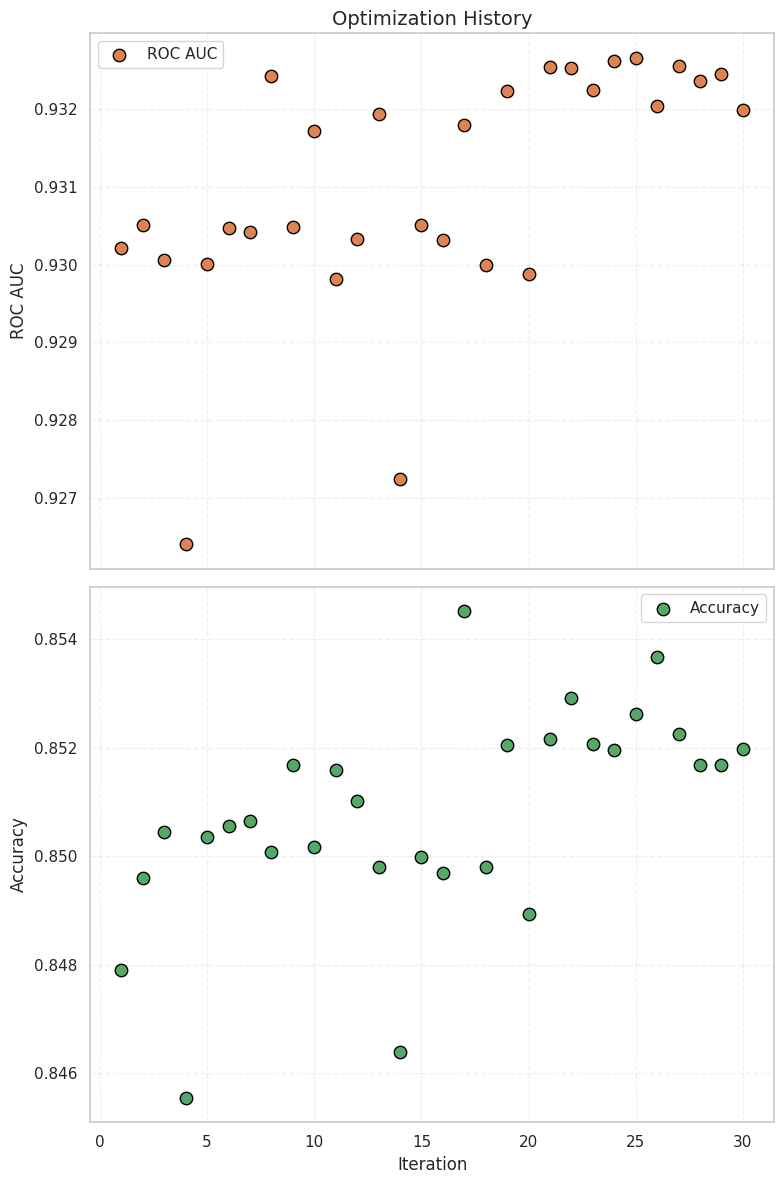

Train & and validate using the Following Parameters: 
 {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 466}


In [ ]:
np.random.seed(42)
# Initialize RandomForestClassifier
rf_clf = RandomForestClassifier()

# Set up number of evaluations and Trials object
n_evals = 30
rf_trials = Trials()

# Define search space
rf_search_space = {
    'max_features': "sqrt",
    'n_estimators': hp_scope.int(hp.quniform('n_estimators', 32, 512, 1)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])
}

# Create an instance of numpy RandomState
# rng = np.random.RandomState().randint(2**31 - 1)

# Run optimization
rf_tune = fmin(
    partial(objective_func, clf=rf_clf, xdata=X_train_out, ydata=Y_train_out, cv_resample=inner_cv),
    space=rf_search_space,
    algo=tpe.suggest,
    trials=rf_trials,
    max_evals=n_evals
)
# # Run optimization
# rf_tune = fmin(
#     partial(objective_func, clf=rf_clf, xdata=X_train_out, ydata=Y_train_out, cv_resample=inner_cv),
#     space=rf_search_space,
#     algo=tpe.suggest,
#     trials=rf_trials,
#     max_evals=n_evals,
#     rstate=rng
# )

# Output the optimization history
rf_optimization_df, rf_best_hp = optimization_trails(rf_trials, rf_search_space)

# Plot optimization history of Random Forest
fig, ax = optimization_history(rf_trials)
plt.show()

# Generate final scores
rf_scores, rf_scores_raw = tunned_model_evaluation(clf=rf_clf, opt_hp=space_eval(rf_search_space, rf_tune), x=X_Data, y=Y_Data, cv=outer_cv, scores=score_metrics)

# Generate and Compute ROC curve
_, rf_roc_data = generate_roc_data(rf_clf.set_params(**space_eval(rf_search_space, rf_tune)), X_train_out, Y_train_out, X_test_out, Y_test_out)

In [ ]:
import numpy as np

# Concatenate X_train_out
X_train_combined = np.vstack(X_train_out)

# Concatenate Y_train_out
Y_train_combined = np.concatenate(Y_train_out)

print("X_train_combined shape:", X_train_combined.shape)
print("Y_train_combined shape:", Y_train_combined.shape)

# Now try fitting the model
rf_clf_tuned = rf_clf.set_params(**space_eval(rf_search_space, rf_tune))
rf_clf_tuned.fit(X_train_combined, Y_train_combined)

X_train_combined shape: (10592, 14)
Y_train_combined shape: (10592,)


RandomForestClassifier(criterion='entropy', n_estimators=466)

Information Gain for each feature:
DT_FAULT: 0.6471
ELE: 0.5548
PROF_CUR: 0.5164
ASPECT: 0.5163
PLAN_CUR: 0.5140
DT_ROAD: 0.4820
DT_RIVER: 0.3957
LULC: 0.0970
GEOLOGY: 0.0897
SOIL: 0.0793
LITHOLOGY: 0.0525
PGA: 0.0391
RAIN: 0.0274
CURVE: 0.0101


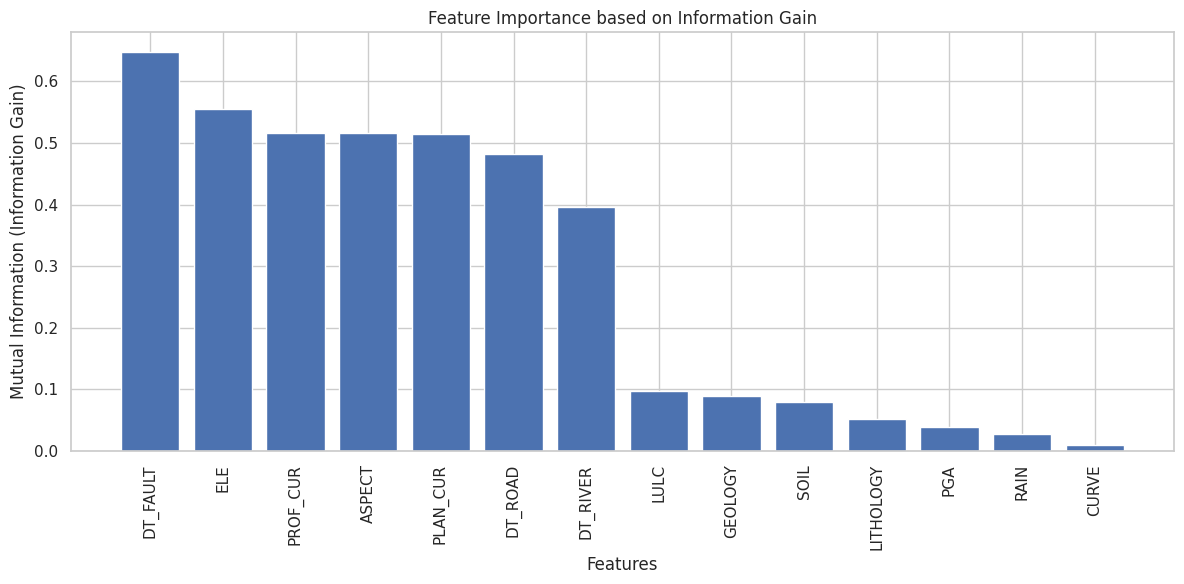


Random Forest Feature Importances:
ELE: 0.2102
DT_ROAD: 0.1930
DT_FAULT: 0.1059
DT_RIVER: 0.0913
ASPECT: 0.0649
PROF_CUR: 0.0542
LITHOLOGY: 0.0519
PLAN_CUR: 0.0498
LULC: 0.0351
PGA: 0.0348
CURVE: 0.0312
RAIN: 0.0301
SOIL: 0.0257
GEOLOGY: 0.0219


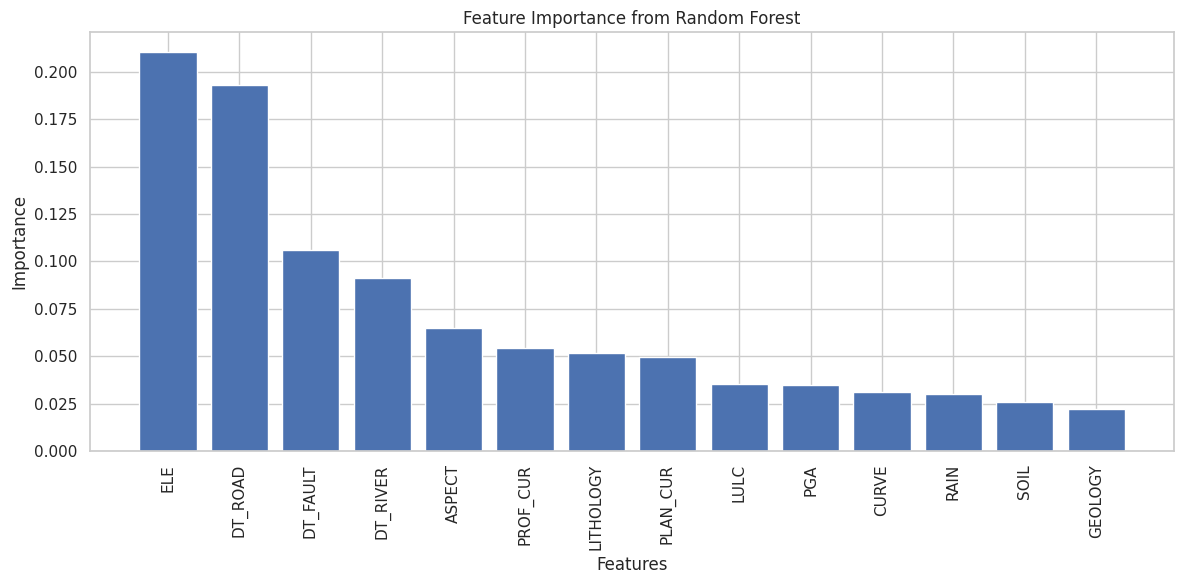

In [ ]:
from sklearn.feature_selection import mutual_info_classif
import numpy as np
import matplotlib.pyplot as plt

# Extract feature names from the column names of input_df
feature_names = list(input_df.columns)

# Remove 'Landslides' if it's the target variable and not a feature
if 'Landslides' in feature_names:
    feature_names.remove('Landslides')

# Calculate mutual information between features and target
mutual_info = mutual_info_classif(X_train_combined, Y_train_combined)

# Create a dictionary of feature names and their mutual information scores
feature_importance = dict(zip(feature_names, mutual_info))

# Sort features by importance
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Print the sorted features and their importance scores
print("Information Gain for each feature:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Visualize the feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importance)), [imp for _, imp in sorted_features])
plt.xticks(range(len(feature_importance)), [feat for feat, _ in sorted_features], rotation=90)
plt.xlabel('Features')
plt.ylabel('Mutual Information (Information Gain)')
plt.title('Feature Importance based on Information Gain')
plt.tight_layout()
plt.show()

# Get feature importances from the Random Forest model
rf_importances = rf_clf_tuned.feature_importances_
rf_feature_importance = dict(zip(feature_names, rf_importances))
sorted_rf_features = sorted(rf_feature_importance.items(), key=lambda x: x[1], reverse=True)

print("\nRandom Forest Feature Importances:")
for feature, importance in sorted_rf_features:
    print(f"{feature}: {importance:.4f}")

# Visualize Random Forest feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(len(rf_feature_importance)), [imp for _, imp in sorted_rf_features])
plt.xticks(range(len(rf_feature_importance)), [feat for feat, _ in sorted_rf_features], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.show()

 ## Tunning Extra Trees


 Results

    Iterations: 1
    Loss (negative ROC AUC): -0.93250
    Accuracy: 0.85480
    using: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 304}


 Results

    Iterations: 2
    Loss (negative ROC AUC): -0.93086
    Accuracy: 0.85272
    using: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 81}


 Results

    Iterations: 3
    Loss (negative ROC AUC): -0.93302
    Accuracy: 0.85499
    using: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 493}


 Results

    Iterations: 4
    Loss (negative ROC AUC): -0.93323
    Accuracy: 0.85518
    using: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 456}


 Results

    Iterations: 5
    Loss (negative ROC AUC): -0.93310
    Accuracy: 0.85452
    using: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 435}


 Results

    Iterations: 6
    Loss (negative ROC AUC): -0.93335
    Accuracy: 0.85678
    using: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_

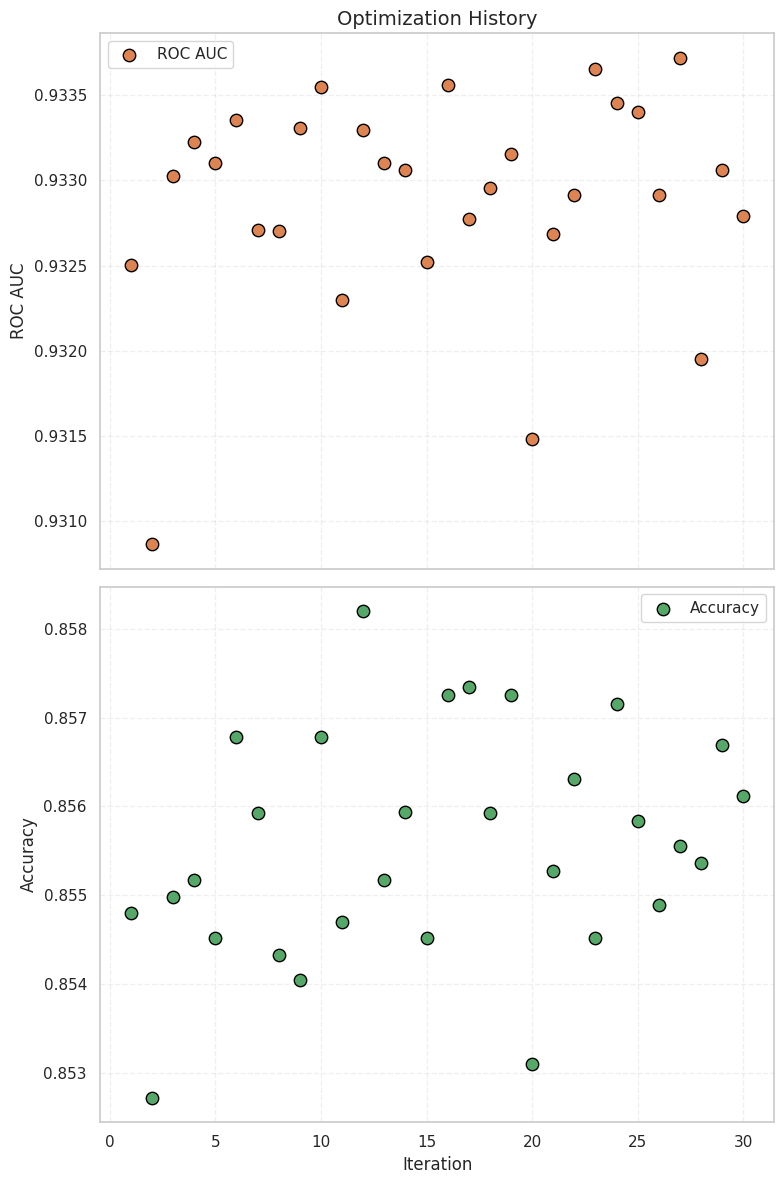

Train & and validate using the Following Parameters: 
 {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 482}


In [ ]:
count=0
np.random.seed(42)
# # Init. model function for the objective function:
ext_clf = ExtraTreesClassifier()

# # Setting up number of evaluations and Trials object
n_evals = 30
ext_trails = Trials()

ext_search_space = {
        'max_features': "sqrt",
        'n_estimators': hp_scope.int(hp.quniform('n_estimators', 32,512,1)),
        'criterion': hp.choice('criterion', ["gini", "entropy"])
        }

# # Running optimization
ext_tune = fmin(partial(objective_func, clf= ext_clf, xdata=X_train_out, ydata=Y_train_out,cv_resample=inner_cv),
                space=ext_search_space, algo=tpe.suggest,
                trials=ext_trails, max_evals=n_evals)

# Output the optimization history
ext_optimization_df, ext_best_hp = optimization_trails(ext_trails,ext_search_space)

# Plot optimization history of Random Forest
fig, ax = optimization_history(ext_trails)
plt.show()

# Generate final scores
ext_scores, ext_scores_raw  = tunned_model_evaluation(clf=ext_clf,opt_hp=space_eval(ext_search_space,ext_tune),x=X_Data,y=Y_Data,cv=outer_cv,scores=score_metrics)

# Generate and Compute ROC curve
_, ext_roc_data = generate_roc_data(ext_clf.set_params(**space_eval(ext_search_space,ext_tune)),X_train_out,Y_train_out,X_test_out,Y_test_out)

In [ ]:
input_df.iloc[0]


ASPECT          45.000
CURVE           -1.280
ELE           1608.000
PLAN_CUR        -0.480
PROF_CUR         0.800
DT_ROAD        478.441
DT_RIVER      1552.120
DT_FAULT      9307.400
RAIN             5.000
PGA              6.000
LITHOLOGY        8.000
GEOLOGY          8.000
SOIL             1.000
LULC             1.000
Landslides       0.000
Name: 0, dtype: float64

Information Gain for each feature:
DT_FAULT: 0.6475
ELE: 0.5541
PROF_CUR: 0.5208
PLAN_CUR: 0.5166
ASPECT: 0.5139
DT_ROAD: 0.4810
DT_RIVER: 0.3938
LULC: 0.1007
GEOLOGY: 0.0972
SOIL: 0.0760
LITHOLOGY: 0.0589
PGA: 0.0348
RAIN: 0.0347
CURVE: 0.0094


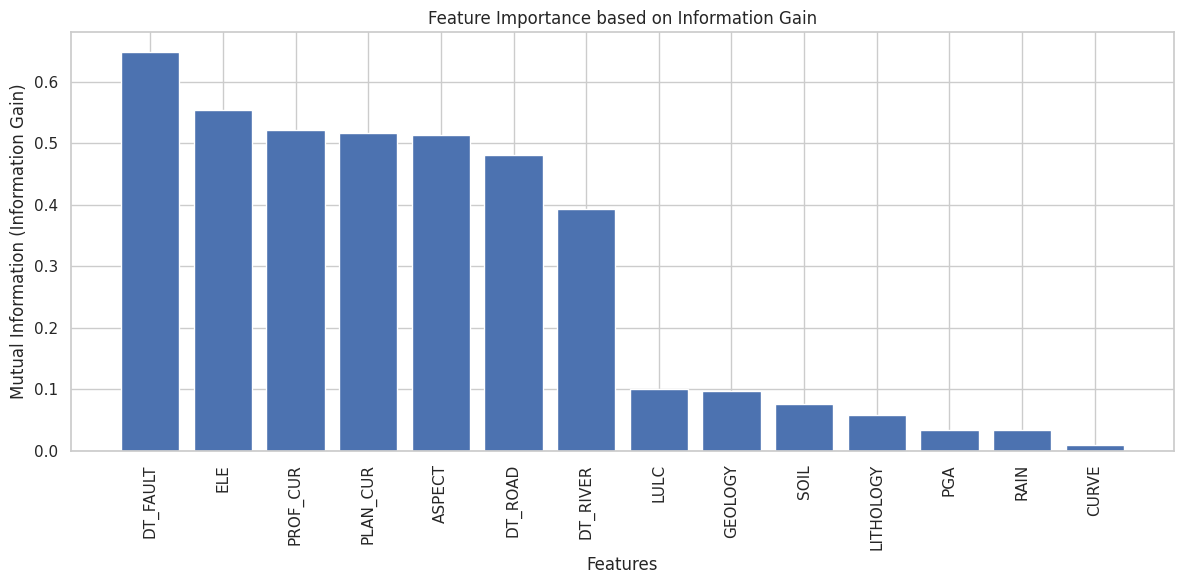


Extra Trees Feature Importances:
ELE: 0.2084
DT_ROAD: 0.1439
DT_FAULT: 0.0940
DT_RIVER: 0.0774
LITHOLOGY: 0.0706
ASPECT: 0.0597
LULC: 0.0496
RAIN: 0.0489
PGA: 0.0463
PROF_CUR: 0.0453
PLAN_CUR: 0.0448
CURVE: 0.0415
GEOLOGY: 0.0375
SOIL: 0.0322


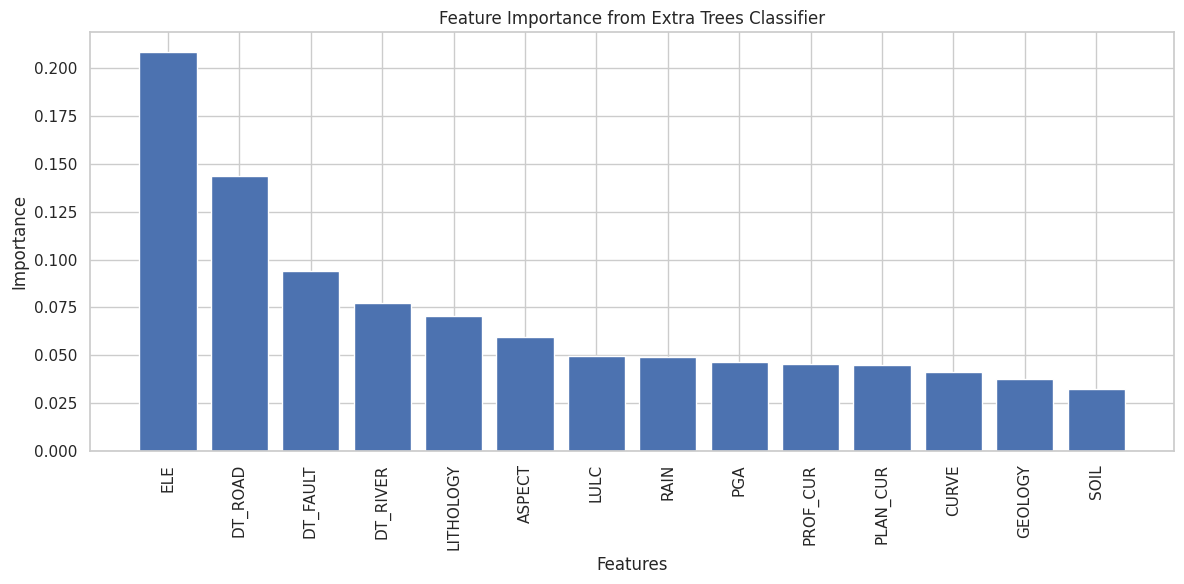

In [ ]:
from sklearn.feature_selection import mutual_info_classif
import numpy as np
import matplotlib.pyplot as plt

# Extract feature names from the column names of input_df
feature_names = list(input_df.columns)

# Remove 'Landslides' if it's the target variable and not a feature
if 'Landslides' in feature_names:
    feature_names.remove('Landslides')

# Combine X_train_out into a single array if it's not already
if isinstance(X_train_out, list):
    X_train_combined = np.vstack(X_train_out)
else:
    X_train_combined = X_train_out

# Combine Y_train_out into a single array if it's not already
if isinstance(Y_train_out, list):
    Y_train_combined = np.concatenate(Y_train_out)
else:
    Y_train_combined = Y_train_out

# Calculate mutual information between features and target
mutual_info = mutual_info_classif(X_train_combined, Y_train_combined)

# Create a dictionary of feature names and their mutual information scores
feature_importance = dict(zip(feature_names, mutual_info))

# Sort features by importance
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Print the sorted features and their importance scores
print("Information Gain for each feature:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Visualize the feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importance)), [imp for _, imp in sorted_features])
plt.xticks(range(len(feature_importance)), [feat for feat, _ in sorted_features], rotation=90)
plt.xlabel('Features')
plt.ylabel('Mutual Information (Information Gain)')
plt.title('Feature Importance based on Information Gain')
plt.tight_layout()
plt.show()

# Get feature importances from the Extra Trees model
ext_clf_tuned = ext_clf.set_params(**space_eval(ext_search_space, ext_tune))
ext_clf_tuned.fit(X_train_combined, Y_train_combined)
ext_importances = ext_clf_tuned.feature_importances_

ext_feature_importance = dict(zip(feature_names, ext_importances))
sorted_ext_features = sorted(ext_feature_importance.items(), key=lambda x: x[1], reverse=True)

print("\nExtra Trees Feature Importances:")
for feature, importance in sorted_ext_features:
    print(f"{feature}: {importance:.4f}")

# Visualize Extra Trees feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(len(ext_feature_importance)), [imp for _, imp in sorted_ext_features])
plt.xticks(range(len(ext_feature_importance)), [feat for feat, _ in sorted_ext_features], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance from Extra Trees Classifier')
plt.tight_layout()
plt.show()

 ## Tunning Passive Aggressive Algorithms


 Results

    Iterations: 1
    Loss (negative ROC AUC): -0.71057
    Accuracy: 0.63801
    using: {'C': 0.5040437707436863, 'early_stopping': True, 'fit_intercept': 1, 'max_iter': 612, 'n_iter_no_change': 10}


 Results

    Iterations: 2
    Loss (negative ROC AUC): -0.71772
    Accuracy: 0.63405
    using: {'C': 0.15467931195973494, 'early_stopping': True, 'fit_intercept': 1, 'max_iter': 743, 'n_iter_no_change': 10}


 Results

    Iterations: 3
    Loss (negative ROC AUC): -0.64436
    Accuracy: 0.61330
    using: {'C': 10.688492730790381, 'early_stopping': True, 'fit_intercept': 1, 'max_iter': 920, 'n_iter_no_change': 10}


 Results

    Iterations: 4
    Loss (negative ROC AUC): -0.65795
    Accuracy: 0.64106
    using: {'C': 0.07496012057282905, 'early_stopping': True, 'fit_intercept': 0, 'max_iter': 828, 'n_iter_no_change': 10}


 Results

    Iterations: 5
    Loss (negative ROC AUC): -0.68462
    Accuracy: 0.64660
    using: {'C': 0.05179140464914835, 'early_stopping': True,

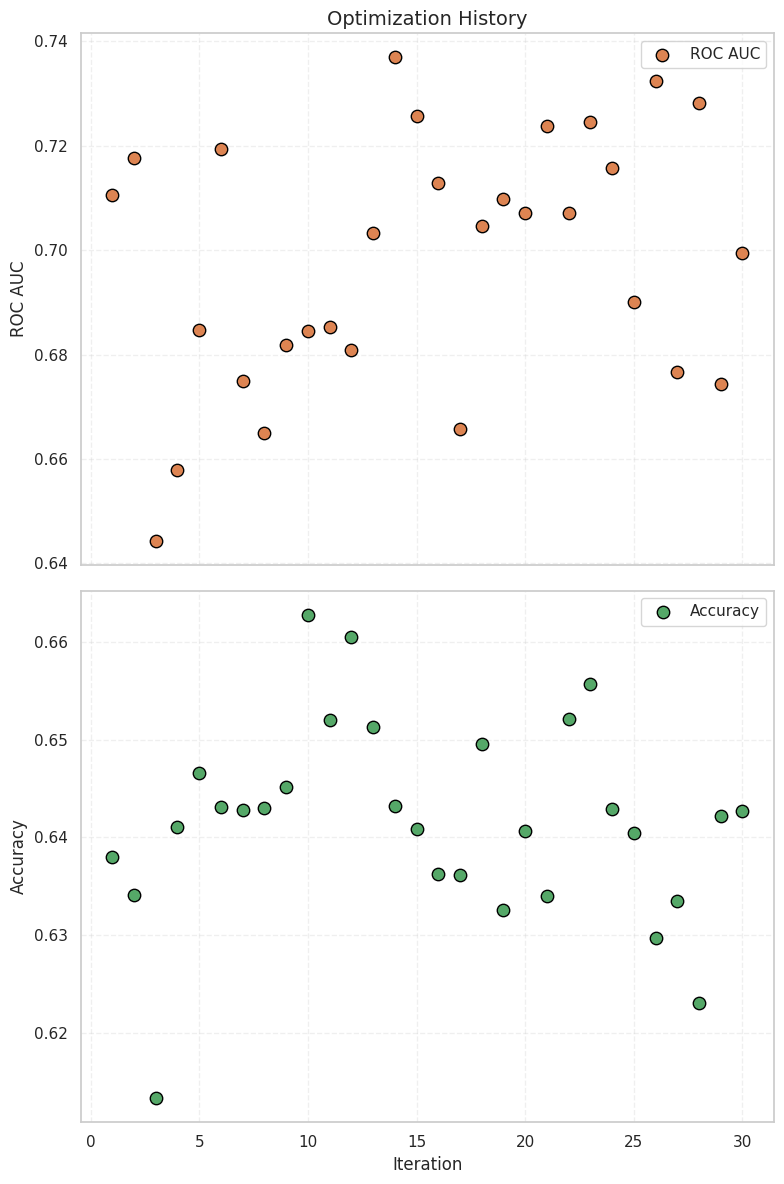

Train & and validate using the Following Parameters: 
 {'C': 3.911504214826237, 'early_stopping': True, 'fit_intercept': 0, 'max_iter': 895, 'n_iter_no_change': 10}


In [ ]:
count=0
np.random.seed(42)
# # Init. model function for the objective function:
pa_clf = PassiveAggressiveClassifier()

# # Setting up number of evaluations and Trials object
n_evals = 30
pa_trails = Trials()

pa_search_space = {
        'C': hp.loguniform('C', -3,3),
        'early_stopping': True,
        'n_iter_no_change': 10,
        'max_iter': hp_scope.int(hp.quniform('max_iter', 128,1024,1)),
        'fit_intercept': hp.choice('fit_intercept', [0, 1])
        }

# # Running optimization
pa_tune = fmin(partial(objective_func, clf= pa_clf, xdata=X_train_out, ydata=Y_train_out,cv_resample=inner_cv),
                space=pa_search_space, algo=tpe.suggest,
                trials=pa_trails, max_evals=n_evals)

# Output the optimization history
pa_optimization_df, pa_best_hp = optimization_trails(pa_trails,pa_search_space)

# Plot optimization history of Random Forest
fig, ax = optimization_history(pa_trails)
plt.show()

# Generate final scores
pa_scores, pa_scores_raw  = tunned_model_evaluation(clf=pa_clf,opt_hp=space_eval(pa_search_space,pa_tune),x=X_Data,y=Y_Data,cv=outer_cv,scores=score_metrics)

# Generate and Compute ROC curve
# _, pa_roc_data = generate_roc_data(pa_clf.set_params(**space_eval(pa_search_space,pa_tune)),X_train_out,Y_train_out,X_test_out,Y_test_out)



 ## Tunning Gaussian Naive Bayes


 Results

    Iterations: 1
    Loss (negative ROC AUC): -0.83971
    Accuracy: 0.75953
    using: {'var_smoothing': 1e-09}


 Results

    Iterations: 2
    Loss (negative ROC AUC): -0.83971
    Accuracy: 0.75953
    using: {'var_smoothing': 1e-09}

100%|██████████| 2/2 [00:00<00:00,  5.22trial/s, best loss: -0.8397133464947879]


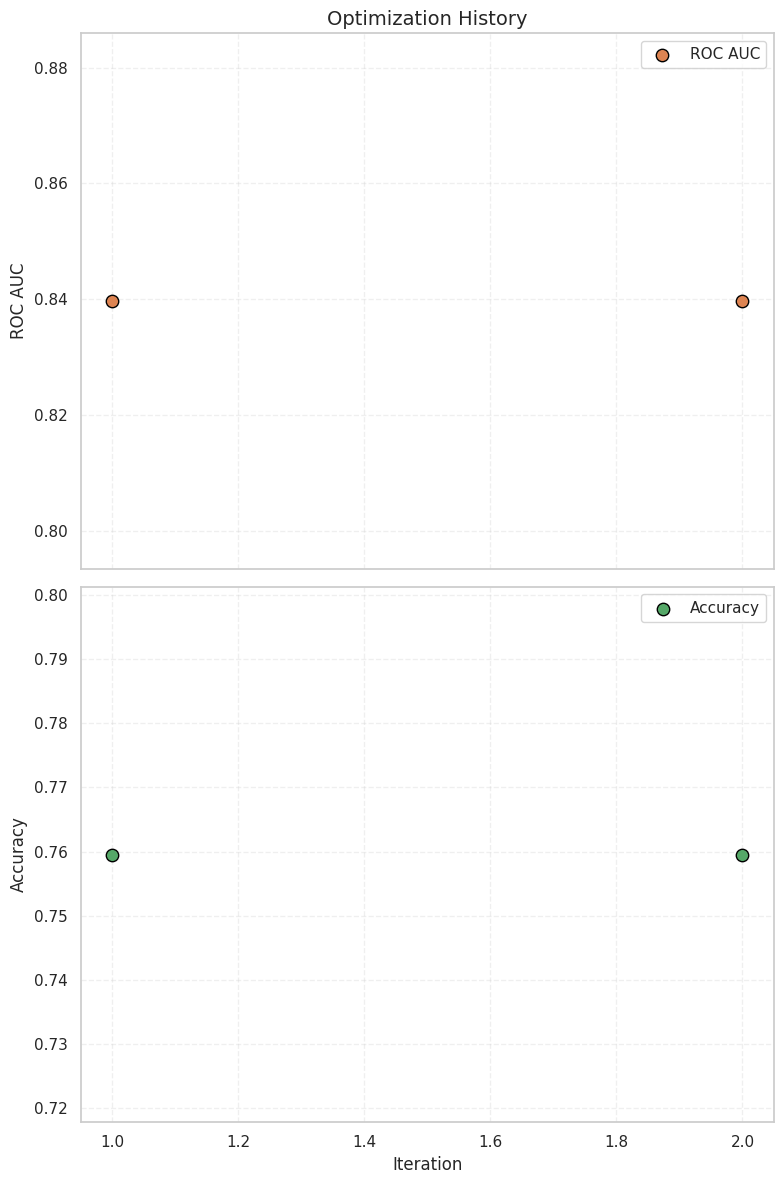

Train & and validate using the Following Parameters: 
 {'var_smoothing': 1e-09}


In [ ]:
np.random.seed(42)
# Init. model function for the objective function:
# nb_clf = BernoulliNB()
nb_clf = GaussianNB()

# Setting up number of evaluations and Trials object
n_evals = 2
nb_trails = Trials()

nb_search_space =  {
        # 'alpha': hp.uniform('alpha', 0.0, 2.0)
        "var_smoothing": 1e-9
        }

# Running optimization
nb_tune = fmin(partial(objective_func, clf= nb_clf, xdata=X_train_out, ydata=Y_train_out,cv_resample=inner_cv),
                space=nb_search_space, algo=tpe.suggest,
                trials=nb_trails, max_evals=n_evals)

# Output the optimization history
nb_optimization_df, nb_best_hp = optimization_trails(nb_trails,nb_search_space)

# Plot optimization history of Random Forest
fig, ax = optimization_history(nb_trails)
plt.show()

# Generate final scores
nb_scores, nb_scores_raw = tunned_model_evaluation(clf=nb_clf,opt_hp=space_eval(nb_search_space,nb_tune),x=X_Data,y=Y_Data,cv=outer_cv,scores=score_metrics)

# Generate and Compute ROC curve
_, nb_roc_data = generate_roc_data(nb_clf.set_params(**space_eval(nb_search_space,nb_tune)),X_train_out,Y_train_out,X_test_out,Y_test_out)



 ## Tunning Quadratic Analysis


 Results

    Iterations: 3
    Loss (negative ROC AUC): -0.86380
    Accuracy: 0.76718
    using: {'tol': 0.0001}


 Results

    Iterations: 4
    Loss (negative ROC AUC): -0.86380
    Accuracy: 0.76718
    using: {'tol': 0.0001}

100%|██████████| 2/2 [00:00<00:00,  3.52trial/s, best loss: -0.8637975337312815]


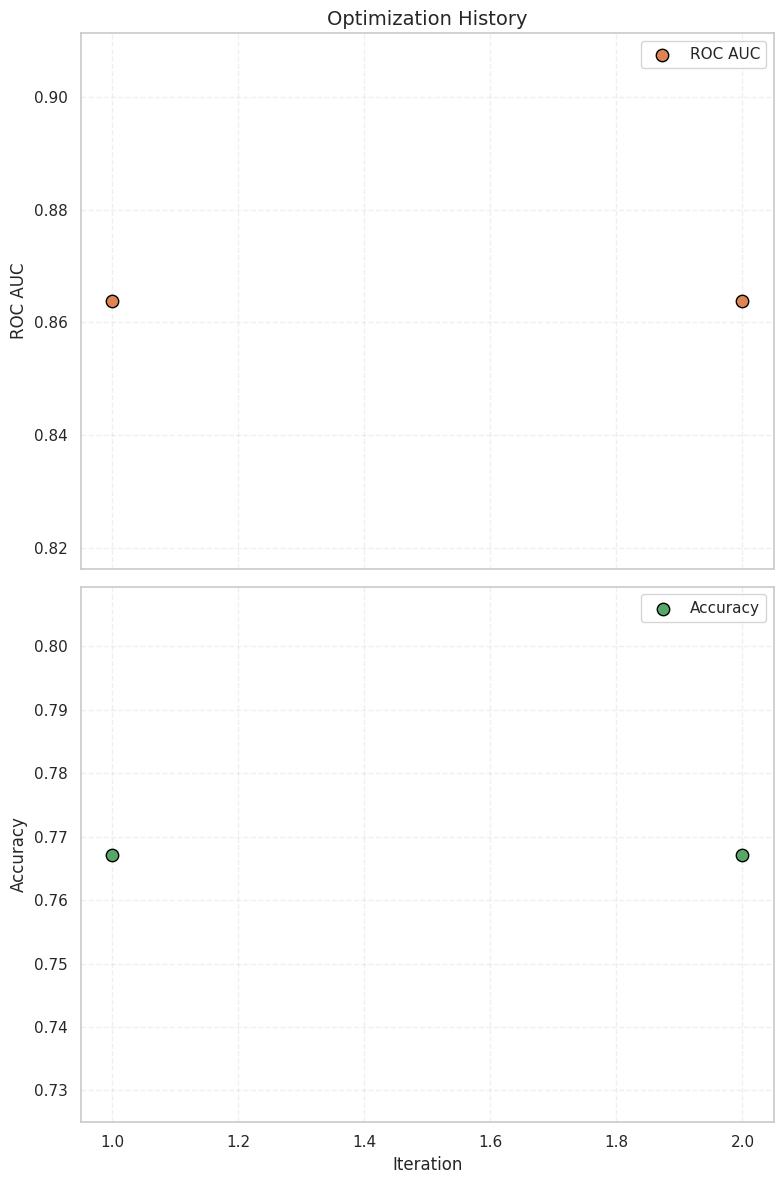

Train & and validate using the Following Parameters: 
 {'tol': 0.0001}


In [ ]:
np.random.seed(42)
# Init. model function for the objective function:
qd_clf = QuadraticDiscriminantAnalysis()

# Setting up number of evaluations and Trials object
n_evals = 2
qd_trails = Trials()

qd_search_space =  {"tol": 1e-4}

# Running optimization
qd_tune = fmin(partial(objective_func, clf= qd_clf, xdata=X_train_out, ydata=Y_train_out,cv_resample=inner_cv),
                space=qd_search_space, algo=tpe.suggest,
                trials=qd_trails, max_evals=n_evals)

# Output the optimization history
qd_optimization_df, qd_best_hp = optimization_trails(qd_trails,qd_search_space)

# Plot optimization history of Random Forest
fig, ax = optimization_history(qd_trails)
plt.show()

# Generate final scores
qd_scores, qd_scores_raw = tunned_model_evaluation(clf=qd_clf,opt_hp=space_eval(qd_search_space,qd_tune),x=X_Data,y=Y_Data,cv=outer_cv,scores=score_metrics)

# Generate and Compute ROC curve
_, qd_roc_data = generate_roc_data(qd_clf.set_params(**space_eval(qd_search_space,qd_tune)),X_train_out,Y_train_out,X_test_out,Y_test_out)


 ## Tunning Logistic Regression


 Results

    Iterations: 1
    Loss (negative ROC AUC): -0.88438
    Accuracy: 0.81420
    using: {'C': 1.0, 'solver': 'lbfgs'}


 Results

    Iterations: 2
    Loss (negative ROC AUC): -0.88438
    Accuracy: 0.81420
    using: {'C': 1.0, 'solver': 'lbfgs'}

100%|██████████| 2/2 [00:06<00:00,  3.49s/trial, best loss: -0.8843835732741793]


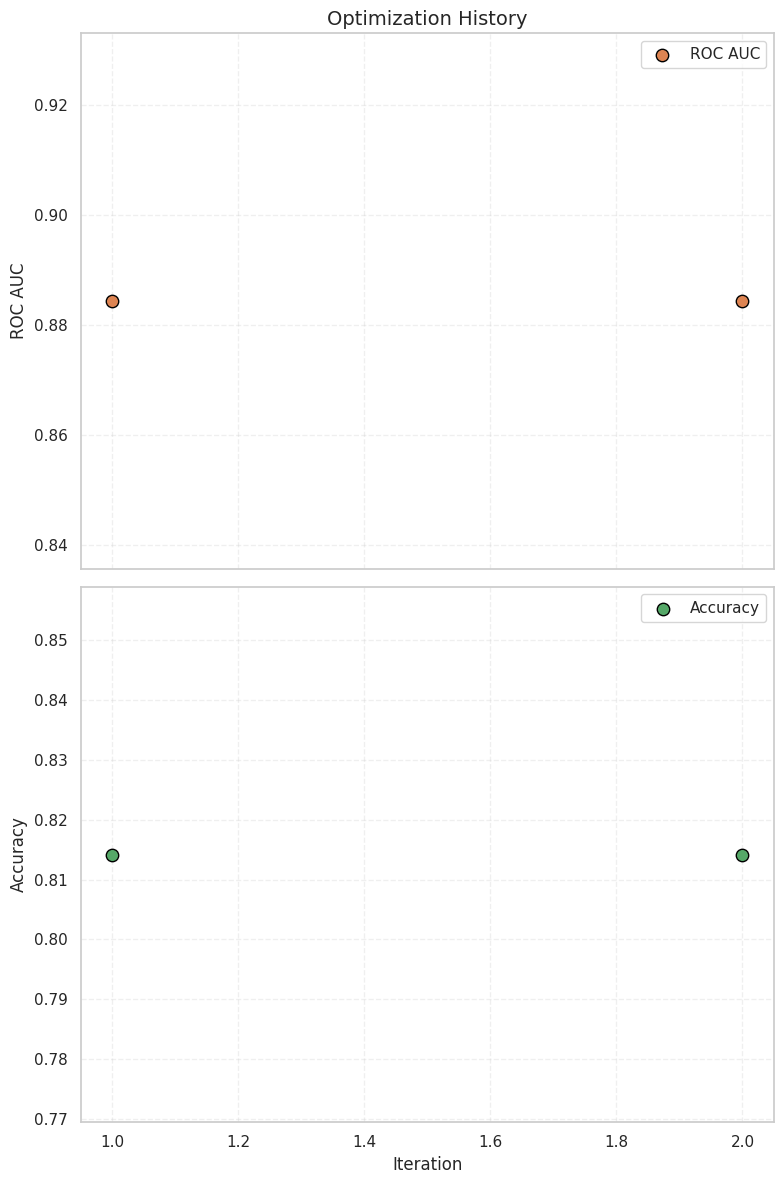

Train & and validate using the Following Parameters: 
 {'C': 1.0, 'solver': 'lbfgs'}


In [ ]:
count=0
np.random.seed(42)
# Init. model function for the objective function:
lr_clf = LogisticRegression()

# Setting up number of evaluations and Trials object
n_evals = 2
lr_trails = Trials()

lr_search_space =  {"C": 1.0,"solver":'lbfgs'}

# Running optimization
lr_tune = fmin(partial(objective_func, clf= lr_clf, xdata=X_train_out, ydata=Y_train_out,cv_resample=inner_cv),
                space=lr_search_space, algo=tpe.suggest,
                trials=lr_trails, max_evals=n_evals)

# Output the optimization history
lr_optimization_df, lr_best_hp = optimization_trails(lr_trails,lr_search_space)

# Plot optimization history of Random Forest
fig, ax = optimization_history(lr_trails)
plt.show()

# Generate final scores
lr_scores, lr_scores_raw = tunned_model_evaluation(clf=lr_clf,opt_hp=space_eval(lr_search_space,lr_tune),x=X_Data,y=Y_Data,cv=outer_cv,scores=score_metrics)

# Generate and Compute ROC curve
_, lr_roc_data = generate_roc_data(lr_clf.set_params(**space_eval(lr_search_space,lr_tune)),X_train_out,Y_train_out,X_test_out,Y_test_out)


 ## Tunning K-Nearest Neighbors


 Results

    Iterations: 1
    Loss (negative ROC AUC): -0.87441
    Accuracy: 0.79475
    using: {'n_neighbors': 42, 'p': 3, 'weights': 'uniform'}


 Results

    Iterations: 2
    Loss (negative ROC AUC): -0.87491
    Accuracy: 0.79975
    using: {'n_neighbors': 9, 'p': 4, 'weights': 'uniform'}


 Results

    Iterations: 3
    Loss (negative ROC AUC): -0.87382
    Accuracy: 0.79107
    using: {'n_neighbors': 47, 'p': 3, 'weights': 'uniform'}


 Results

    Iterations: 4
    Loss (negative ROC AUC): -0.87475
    Accuracy: 0.79702
    using: {'n_neighbors': 32, 'p': 3, 'weights': 'uniform'}


 Results

    Iterations: 5
    Loss (negative ROC AUC): -0.87507
    Accuracy: 0.79447
    using: {'n_neighbors': 31, 'p': 5, 'weights': 'uniform'}


 Results

    Iterations: 6
    Loss (negative ROC AUC): -0.87165
    Accuracy: 0.79484
    using: {'n_neighbors': 6, 'p': 3, 'weights': 'uniform'}


 Results

    Iterations: 7
    Loss (negative ROC AUC): -0.87764
    Accuracy: 0.79636
    usi

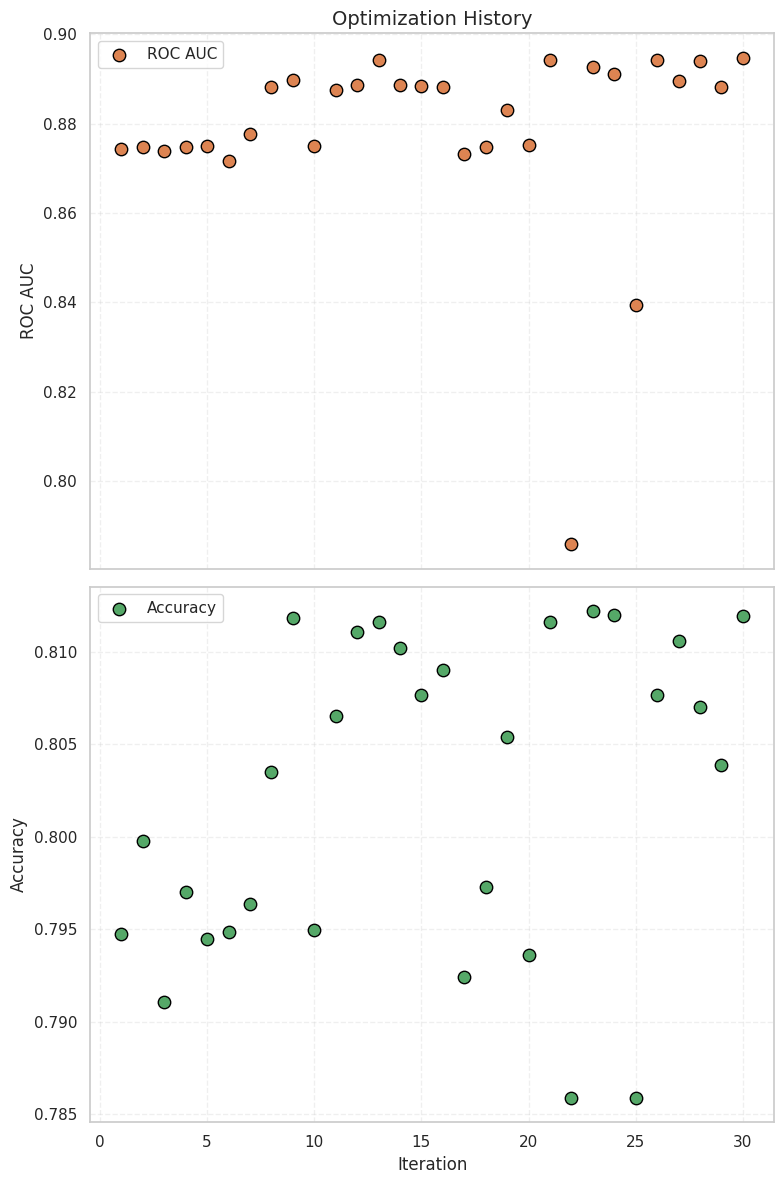

Train & and validate using the Following Parameters: 
 {'n_neighbors': 20, 'p': 1, 'weights': 'distance'}


In [ ]:
count=0
np.random.seed(42)
# Init. model function for the objective function:
knn_clf = KNeighborsClassifier()

# Setting up number of evaluations and Trials object
n_evals = 30
knn_trails = Trials()

knn_search_space =  {
        'n_neighbors': hp_scope.int(hp.quniform('knn_n_neighbors', 1, 50,1)),
        'p': hp_scope.int(hp.quniform('p', 1, 5,1)),
        'weights': hp.choice('weights', ["uniform","distance"])
        }

# Running optimization
knn_tune = fmin(partial(objective_func, clf= knn_clf, xdata=X_train_out, ydata=Y_train_out,cv_resample=inner_cv),
                space=knn_search_space, algo=tpe.suggest,
                trials=knn_trails, max_evals=n_evals)

# Output the optimization history
knn_optimization_df, knn_best_hp = optimization_trails(knn_trails,knn_search_space)

# Plot optimization history of Random Forest
fig, ax = optimization_history(knn_trails)
plt.show()

# Generate final scores
knn_scores, knn_scores_raw = tunned_model_evaluation(clf=knn_clf,opt_hp=space_eval(knn_search_space,knn_tune),x=X_Data,y=Y_Data,cv=outer_cv,scores=score_metrics)

# Generate and Compute ROC curve
_, knn_roc_data = generate_roc_data(knn_clf.set_params(**space_eval(knn_search_space,knn_tune)),X_train_out,Y_train_out,X_test_out,Y_test_out)



 ## Tunning Decision Trees


 Results

    Iterations: 1
    Loss (negative ROC AUC): -0.88173
    Accuracy: 0.79862
    using: {'criterion': 'gini', 'max_features': 0.8169408864085003, 'min_weight_fraction_leaf': 0.07209467676990505}


 Results

    Iterations: 2
    Loss (negative ROC AUC): -0.76687
    Accuracy: 0.77351
    using: {'criterion': 'gini', 'max_features': 0.6880449634599649, 'min_weight_fraction_leaf': 0.33088066186862825}


 Results

    Iterations: 3
    Loss (negative ROC AUC): -0.88036
    Accuracy: 0.80560
    using: {'criterion': 'gini', 'max_features': 0.4922361198259887, 'min_weight_fraction_leaf': 0.00576133394251771}


 Results

    Iterations: 4
    Loss (negative ROC AUC): -0.74458
    Accuracy: 0.72479
    using: {'criterion': 'entropy', 'max_features': 0.503931525372195, 'min_weight_fraction_leaf': 0.49043195698467723}


 Results

    Iterations: 5
    Loss (negative ROC AUC): -0.88359
    Accuracy: 0.79871
    using: {'criterion': 'entropy', 'max_features': 0.5133410714293392, 'min_

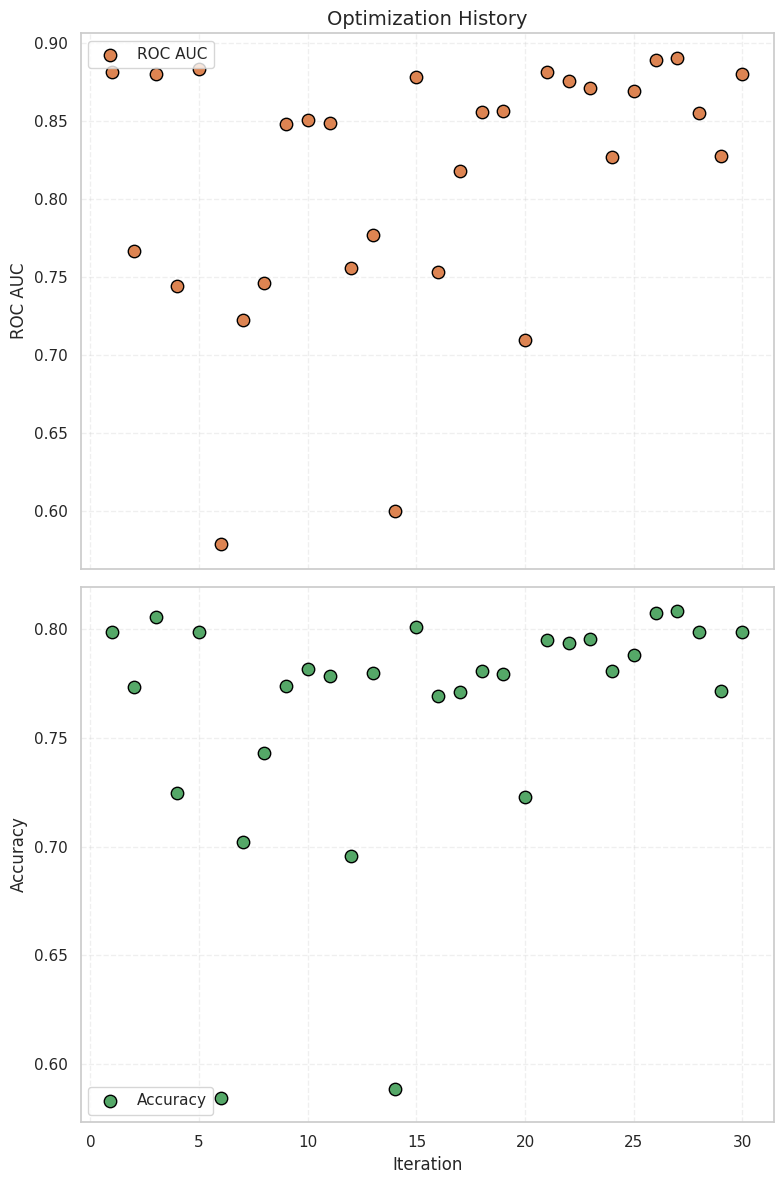

Train & and validate using the Following Parameters: 
 {'criterion': 'entropy', 'max_features': 0.5905623766197716, 'min_weight_fraction_leaf': 0.008927101292093358}


In [ ]:
count=0
np.random.seed(42)
# Init. model function for the objective function:
dt_clf = DecisionTreeClassifier()

# Setting up number of evaluations and Trials object
n_evals = 30
dt_trails = Trials()

dt_search_space = {
        'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0,0.5),
        'max_features': hp.uniform('max_features', 0,1),
        'criterion': hp.choice('criterion', ["gini", "entropy"])
        }

# # Running optimization
# dt_tune = fmin(partial(objective_func, clf= dt_clf, xdata=X_train_out, ydata=Y_train_out,cv_resample=inner_cv),
#                 space=dt_search_space, algo=tpe.suggest,
#                 trials=dt_trails, max_evals=n_evals, rstate=rng)
# Running optimization
dt_tune = fmin(partial(objective_func, clf= dt_clf, xdata=X_train_out, ydata=Y_train_out,cv_resample=inner_cv),
                space=dt_search_space, algo=tpe.suggest,
                trials=dt_trails, max_evals=n_evals)

# Output the optimization history
dt_optimization_df, dt_best_hp = optimization_trails(dt_trails,dt_search_space)

# Plot optimization history of Random Forest
fig, ax = optimization_history(dt_trails)
plt.show()

# Generate final scores
dt_scores, dt_scores_raw = tunned_model_evaluation(clf=DecisionTreeClassifier(),opt_hp=space_eval(dt_search_space,dt_tune),x=X_Data,y=Y_Data,cv=outer_cv,scores=score_metrics)

# Generate and Compute ROC curve
_, dt_roc_data = generate_roc_data(DecisionTreeClassifier(**space_eval(dt_search_space,dt_tune)),X_train_out,Y_train_out,X_test_out,Y_test_out)


 ## Tunning Neural Network


 Results

    Iterations: 1
    Loss (negative ROC AUC): -0.69647
    Accuracy: 0.63801
    using: {'activation': 'relu', 'hidden_layer_sizes': 11, 'max_iter': 128, 'solver': 'lbfgs'}


 Results

    Iterations: 2
    Loss (negative ROC AUC): -0.70486
    Accuracy: 0.63762
    using: {'activation': 'relu', 'hidden_layer_sizes': 29, 'max_iter': 128, 'solver': 'lbfgs'}


 Results

    Iterations: 3
    Loss (negative ROC AUC): -0.68283
    Accuracy: 0.58308
    using: {'activation': 'relu', 'hidden_layer_sizes': 7, 'max_iter': 128, 'solver': 'lbfgs'}


 Results

    Iterations: 4
    Loss (negative ROC AUC): -0.68339
    Accuracy: 0.59689
    using: {'activation': 'relu', 'hidden_layer_sizes': 10, 'max_iter': 128, 'solver': 'lbfgs'}


 Results

    Iterations: 5
    Loss (negative ROC AUC): -0.63455
    Accuracy: 0.62699
    using: {'activation': 'relu', 'hidden_layer_sizes': 35, 'max_iter': 128, 'solver': 'lbfgs'}


 Results

    Iterations: 6
    Loss (negative ROC AUC): -0.61860
    

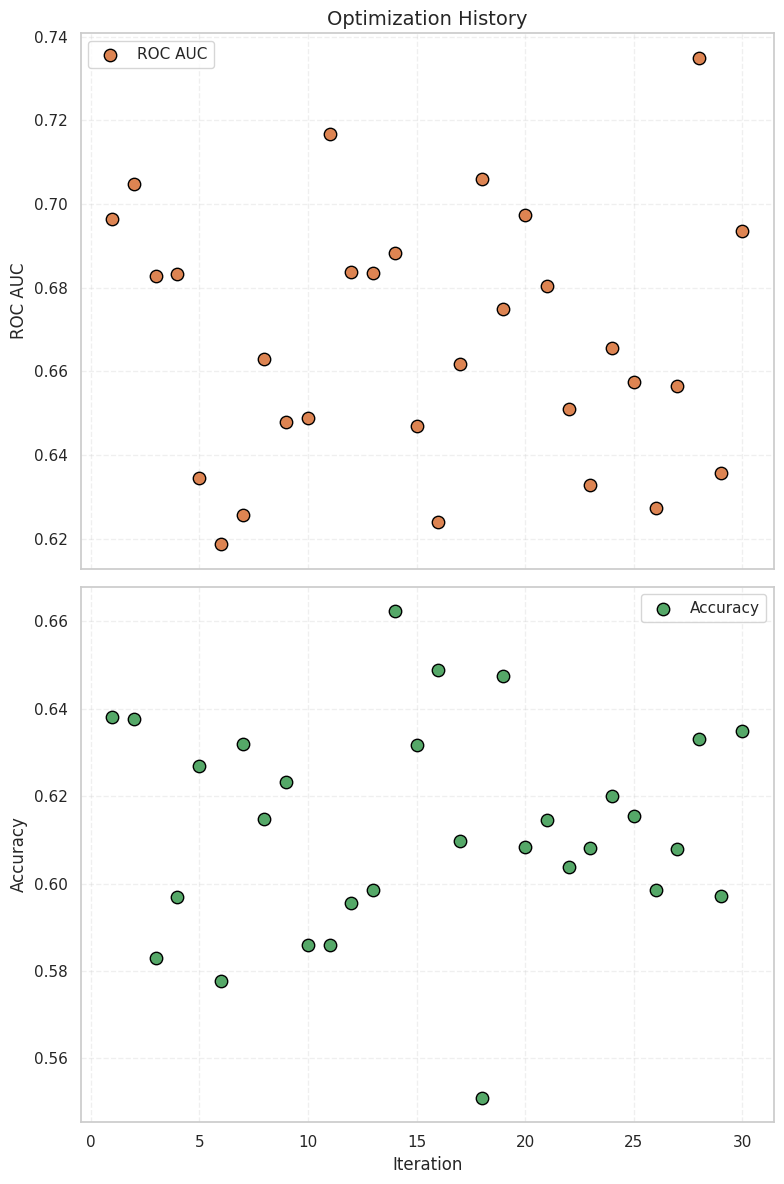

Train & and validate using the Following Parameters: 
 {'activation': 'relu', 'hidden_layer_sizes': 13, 'max_iter': 128, 'solver': 'lbfgs'}


In [ ]:
count=0
np.random.seed(42)
# Init. model function for the objective function:
nnet_clf = MLPClassifier()

# Setting up number of evaluations and Trials object
n_evals = 30
nnet_trails = Trials()

nnet_search_space = {
        'hidden_layer_sizes': hp_scope.int(hp.quniform('hidden_layer_sizes', 3,54,1)),
        'activation': 'relu',
        'solver': 'lbfgs',
        'max_iter': 128
        }

# Running optimization
nnet_tune = fmin(partial(objective_func, clf= nnet_clf, xdata=X_train_out, ydata=Y_train_out,cv_resample=inner_cv),
                space=nnet_search_space, algo=tpe.suggest,
                trials=nnet_trails, max_evals=n_evals)

# Output the optimization history
nnet_optimization_df, nnet_best_hp = optimization_trails(nnet_trails,nnet_search_space)

# Plot optimization history of Random Forest
fig, ax = optimization_history(nnet_trails)
plt.show()

# Generate final scores
nnet_scores, nnet_scores_raw = tunned_model_evaluation(clf=MLPClassifier(),opt_hp=space_eval(nnet_search_space,nnet_tune),x=X_Data,y=Y_Data,cv=outer_cv,scores=score_metrics)

# Generate and Compute ROC curve
_, nnet_roc_data = generate_roc_data(MLPClassifier(**space_eval(nnet_search_space,nnet_tune)),X_train_out,Y_train_out,X_test_out,Y_test_out)


In [ ]:
models_names_list = ['DT','EXT','KNN','LR','NB','NNET','QDA','RF','PA']
models_raw_scores_list = [
                          dt_scores_raw["test_AUC"],
                          ext_scores_raw["test_AUC"],
                          knn_scores_raw["test_AUC"],
                          lr_scores_raw["test_AUC"],
                          nb_scores_raw["test_AUC"],
                          nnet_scores_raw["test_AUC"],
                          qd_scores_raw["test_AUC"],
                          rf_scores_raw["test_AUC"],
                          pa_scores_raw["test_AUC"]
                         ]



# Create the directory if it doesn't exist
os.makedirs("./Output/Tables", exist_ok=True)
os.makedirs("./Output/Figures", exist_ok=True)

sig_df = sig_stat(models_raw_scores_list,models_names_list)
with open("./Output/Tables/sig_test.md",'w') as tabl:
    print(tabulate(sig_df, headers=['Pairwise', 'p.value','t.value'],tablefmt="grid"),file=tabl)



DT vs. EXT:
T: -4.4368722663860085 	 p: 0.0025559000743940073
DT vs. KNN:
T: -0.6581242851823084 	 p: 0.531771742450551
DT vs. LR:
T: 0.7182967489885193 	 p: 0.4930461923608448
DT vs. NB:
T: 3.96035507124546 	 p: 0.0048727996403956165
DT vs. NNET:
T: 3.149939472705371 	 p: 0.032730084152194035
DT vs. QDA:
T: 2.3059189286228623 	 p: 0.050916368451048376
DT vs. RF:
T: -4.345164020809689 	 p: 0.002984204107120383
DT vs. PA:
T: 3.594865324814252 	 p: 0.021794992011047495
EXT vs. KNN:
T: 4.759632092141466 	 p: 0.0015222605359964483
EXT vs. LR:
T: 5.129130318220237 	 p: 0.0011642918220651929
EXT vs. NB:
T: 7.916292225727334 	 p: 0.00015940577561248328
EXT vs. NNET:
T: 3.9408044475176975 	 p: 0.016218707076984012
EXT vs. QDA:
T: 6.487886149542102 	 p: 0.00037274619435692565
EXT vs. RF:
T: 0.17094584428894677 	 p: 0.8685156343066343
EXT vs. PA:
T: 4.271320318461174 	 p: 0.012480227281043579
KNN vs. LR:
T: 1.482760810270479 	 p: 0.1832521901681003
KNN vs. NB:
T: 4.967271338891759 	 p: 0.0027618

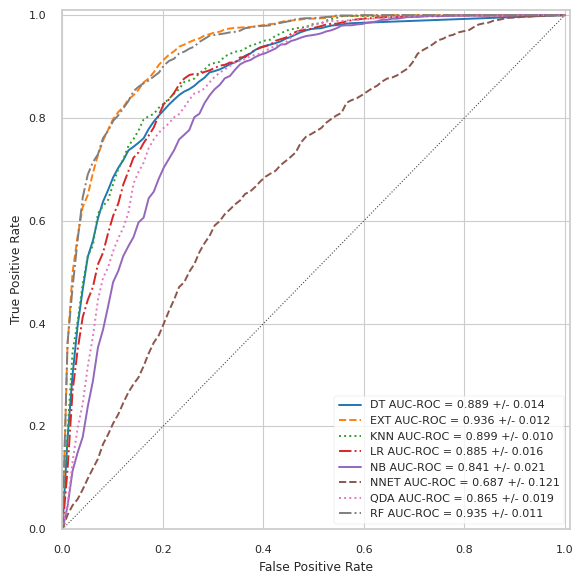

In [ ]:
models_roc_data_list = [
                          dt_roc_data,
                          ext_roc_data,
                          knn_roc_data,
                          lr_roc_data,
                          nb_roc_data,
                          nnet_roc_data,
                          qd_roc_data,
                          rf_roc_data,
                          ]


fig, ax = plot_roc_curves(models_roc_data_list,models_names_list)
ax.set_xlim(0, 1.01)
ax.set_ylim(0, 1.01)

plt.legend(loc="best")
fig.tight_layout()
plt.show()

fig.savefig("./Output/Figures/ROC_plot1.jpg",dpi=600,bbox_inches="tight")


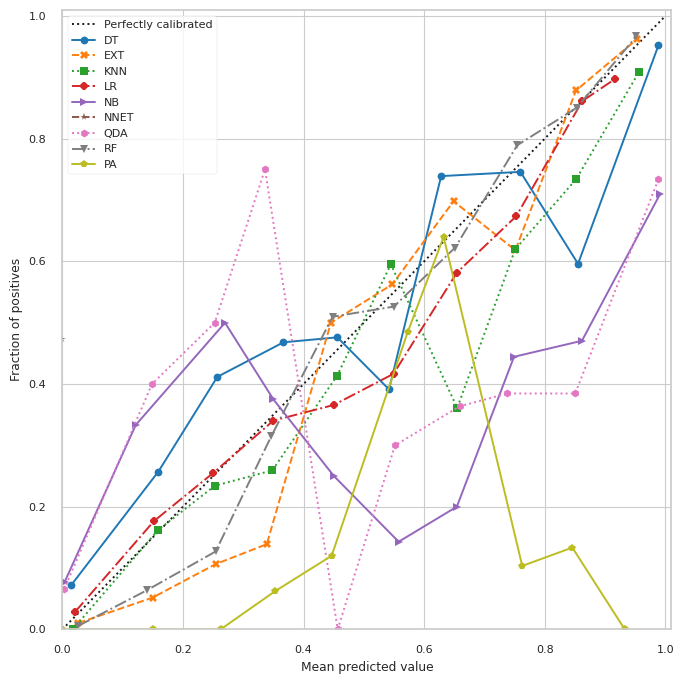

In [ ]:
models_list = [
               dt_clf.set_params(**space_eval(dt_search_space,dt_tune)),
               ext_clf.set_params(**space_eval(ext_search_space,ext_tune)),
               knn_clf.set_params(**space_eval(knn_search_space,knn_tune)),
               lr_clf.set_params(**space_eval(lr_search_space,lr_tune)),
               nb_clf.set_params(**space_eval(nb_search_space,nb_tune)),
               nnet_clf.set_params(**space_eval(nnet_search_space,nnet_tune)),
               qd_clf.set_params(**space_eval(qd_search_space,qd_tune)),
               rf_clf.set_params(**space_eval(rf_search_space,rf_tune)),
               pa_clf.set_params(**space_eval(pa_search_space,pa_tune))
               ]

fig, ax = plot_calibration_curves(clf=models_list,x=X_Data ,y=Y_Data, test_size=0.3, cv = 10, seed=seed, clf_name=models_names_list)
ax.set_xlim(0, 1.01)
ax.set_ylim(0, 1.01)

plt.legend(loc="best")
fig.tight_layout()
plt.show()
fig.savefig("./Output/Figures/Calibration_plot1.jpg",dpi=600, bbox_inches="tight")

